**DATA 301 Final Project** \
Nick Gammal, Vinay Rajaratnam, Katherine Chan, Grant Holland

**Project Plan**

*Goal*: Use an NBA rookie's stats to determine if they will become a veteran, as defined by the NBA. Stats are retrieved from https://stats.nba.com/stats/leaguedashplayerstats (visualized on  https://www.nba.com/stats/players/traditional) and https://stats.nba.com/stats/playerindex (visualized on https://www.nba.com/players).

*Model*: Dense Neural Network with three hidden layers. Dropout and BatchNormalization layers in between every densely connected layer.

*Input Data*: [AGE, GP, MIN, PTS, FG_PCT, FG3_PCT, FT_PCT, OREB, DREB, AST, TOV, STL, BLK, POS]. All input data will be normalized for the season. The scope of our training and validation data will be all seasons from 2003-2017 inclusive.

*Output Data*: Binary value (became a veteran or not).

Imports

In [ ]:
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import models, layers, metrics, callbacks

import matplotlib.pyplot as plt
import seaborn as sbn

Global Variables

In [ ]:
gameplay_url = 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerPosition=&PlusMinus=N&Rank=N&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight='

gameplay_params = {'PlayerExperience': '', 'Season': '2021-22'}

desired_gameplay_stats = [
    'PLAYER_NAME',
    'TEAM_ABBREVIATION',
    'AGE',
    'GP',
    'MIN',
    'PTS',
    'FG_PCT',
    'FG3_PCT',
    'FT_PCT',
    'OREB',
    'DREB',
    'AST',
    'STL',
    'BLK',
    'TOV',
    'PLUS_MINUS'
]

bio_url = 'https://stats.nba.com/stats/playerindex?College=&Country=&DraftPick=&DraftRound=&DraftYear=&Height=&Historical=1&LeagueID=00&Season=2021-22&SeasonType=Regular%20Season&TeamID=0&Weight='

desired_bio_stats = [
    'POSITION',
    'HEIGHT',
    'WEIGHT'
]

headers = {'Accept-Language': 'en-US,en;q=0.9', 'Origin': 'https://www.nba.com', 'Referer': 'https://www.nba.com/', 'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36'}

# Seasonally adjusted stats
SA_stats = [
    'GP',
    'MIN',
    'PTS',
    'FG_PCT',
    'FG3_PCT',
    'FT_PCT',
    'OREB',
    'DREB',
    'AST',
    'TOV',
    'STL',
    'BLK',
    'PLUS_MINUS'
]

# Non seasonally adjusted stats
NSA_stats = [
    'AGE',
    'HEIGHT',
    'WEIGHT'
]

# Stats dependent on minutes
per_minute_stats = [
    'PTS',
    'OREB',
    'DREB',
    'AST',
    'TOV',
    'STL',
    'BLK'
]

ID_columns = [
    'PLAYER_NAME',
    'TEAM_ABBREVIATION',
    'POSITION'
]

NBA_start_year = '1996-97'
NBA_end_year = '2021-22'

Functions

In [ ]:
# Scrapes the NBA website for a dataframe of players and their stats, by year
def get_player_stats(year, experience=''):
  gameplay_params['Season'] = year
  gameplay_params['PlayerExperience'] = experience

  response = requests.get(gameplay_url, params=gameplay_params, headers=headers)
response.raise_for_status()
  json = response.json()
  table = json['resultSets'][0]
  df = pd.DataFrame(table['rowSet'], columns=table['headers']).set_index('PLAYER_ID')
  df[per_minute_stats] = df[per_minute_stats].div(df['MIN'], axis=0)

  return df

# Converts year from 'XXXX-XX' str to XXXX int
def year_str_to_int(year):
  return int(year[:4])

# Converts year from XXXX int to 'XXXX-XX' str
def year_int_to_str(year):
  return str(year)+'-'+str(year+1)[-2:]

# Scrapes the NBA website for a dataframe of all players and their stats over a range of years, and stores in a csv
def scrape_player_stats(start_year, end_year):
  player_stats = pd.DataFrame()
  for year in range(year_str_to_int(start_year), year_str_to_int(end_year)+1):
    season_rookies = get_player_stats(year_int_to_str(year), experience='Rookie')
    season_sophomores = get_player_stats(year_int_to_str(year), experience='Sophomore')
    season_veterans = get_player_stats(year_int_to_str(year), experience='Veteran')
    season_rookies['EXPERIENCE'] = 'Rookie'
    season_sophomores['EXPERIENCE'] = 'Sophomore'
    season_veterans['EXPERIENCE'] = 'Veteran'
    season_data = pd.concat([season_rookies, season_sophomores, season_veterans])
    season_data['YEAR'] = year_int_to_str(year)
    player_stats = player_stats.append(season_data)
    print(year_int_to_str(year)+" done")

  player_stats.to_csv('player_stats.csv')

# Scrapes the NBA website for a dataframe of players and their bio stats, and stores in a csv
def scrape_player_bios():
  response = requests.get(bio_url, headers=headers)
  response.raise_for_status()
  json = response.json()
  table = json['resultSets'][0]
  df = pd.DataFrame(table['rowSet'], columns=table['headers']).set_index('PERSON_ID')
  df = df[df['FROM_YEAR'].astype(int) >= year_str_to_int(NBA_start_year)]

  df.to_csv('player_bios.csv')

# Normalizes the target dataframe using the "using" dataframe
def normalize(target, using=None):
  if using is None:
    using = target

  return (target - using.mean()) / using.std()

# Gets a dataframe of normalized input data for the model from a given year
def get_season_data(year, labeled=False):
  rookies = player_stats[(player_stats['YEAR']==year) & (player_stats['EXPERIENCE']=='Rookie')].copy()
  all_players = player_stats[player_stats['YEAR']==year].copy()
  rookies[SA_stats] = normalize(rookies[SA_stats], using=all_players[SA_stats])

  if labeled:
    rookies['VETERAN'] = rookies.index.isin(veterans).astype(int)

  return rookies

# Gets a dataframe of normalized input data for the model over a range of years
def get_rookie_data(start_year, end_year, labeled=False):
  all_rookies = pd.DataFrame()
  for year in range(year_str_to_int(start_year), year_str_to_int(end_year)+1):
    season_rookies = get_season_data(year_int_to_str(year), labeled=labeled)
    all_rookies = all_rookies.append(season_rookies)

  all_rookies = all_rookies.merge(player_bios, left_index=True, right_index=True)
  all_rookies[NSA_stats] = normalize(all_rookies[NSA_stats])

  OH_encoder = OneHotEncoder(sparse=False)
  one_hots = pd.DataFrame(OH_encoder.fit_transform(all_rookies[['POSITION']]))
  one_hots.index = all_rookies.index
  one_hots.columns = ['C', 'F', 'G']
  all_rookies = all_rookies.merge(one_hots, left_index=True, right_index=True)

  return all_rookies.drop('EXPERIENCE', axis=1)

Scrape Data From NBA Website

In [ ]:
scrape_player_stats(NBA_start_year, NBA_end_year)

1996-97 done
1997-98 done
1998-99 done
1999-00 done
2000-01 done
2001-02 done
2002-03 done
2003-04 done
2004-05 done
2005-06 done
2006-07 done
2007-08 done
2008-09 done
2009-10 done
2010-11 done
2011-12 done
2012-13 done
2013-14 done
2014-15 done
2015-16 done
2016-17 done
2017-18 done
2018-19 done
2019-20 done
2020-21 done
2021-22 done


In [ ]:
scrape_player_bios()

Retrieve Saved Player Data

In [ ]:
player_stats = pd.read_csv('player_stats.csv', index_col=0)
player_bios = pd.read_csv('player_bios.csv', index_col=0)[desired_bio_stats].dropna()
player_bios['HEIGHT'] = player_bios['HEIGHT'].apply(lambda x: int(x[0])*12 + int(x[2:]))
player_bios['POSITION'] = player_bios['POSITION'].apply(lambda x: x[0])

Get Veterans

In [ ]:
veterans = player_stats[player_stats['EXPERIENCE']=='Veteran'].index.drop_duplicates()

Get Model Training Data

In [ ]:
rookie_data = get_rookie_data('2003-04', '2017-18', labeled=True)

In [ ]:
model_features = [
    'AGE',
    'GP',
    'MIN',
    'PTS',
    'FG_PCT',
    'FG3_PCT',
    'FT_PCT',
    'OREB',
    'DREB',
    'AST',
    'TOV',
    'STL',
    'BLK',
    'C',
    'F',
    'G',
]

model_target = 'VETERAN'

X = rookie_data[model_features]
y = rookie_data[model_target]

View Correlation Between Features And Target

In [ ]:
# Top Corrs: GP (0.506), MIN (0.383), AGE (-0.352), FT_PCT (0.290)
corrs = X.corrwith(y)
sorted_corrs = corrs.iloc[(-corrs.abs()).argsort()]
sorted_corrs

GP         0.506556
MIN        0.383246
AGE       -0.352085
FT_PCT     0.290194
FG_PCT     0.235404
PTS        0.187999
FG3_PCT    0.161204
DREB       0.103937
TOV       -0.064630
BLK        0.059986
G         -0.045346
C          0.026960
F          0.026379
STL        0.022188
AST        0.016325
OREB      -0.012371
dtype: float64

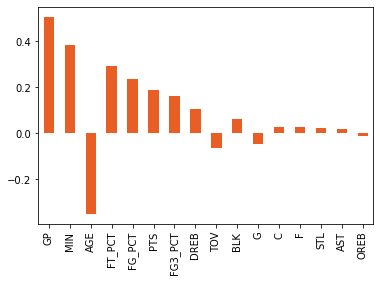

In [ ]:
sorted_corrs.plot.bar(color = "#e95e24")

Visualization of GP and FT_PCT Features in Comparison With Veteran Status

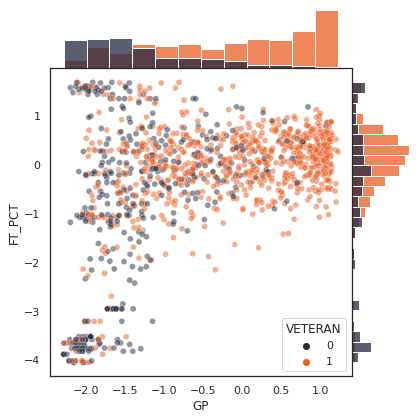

In [ ]:
colormap = ["#242841", "#e95e24"]

sbn.set_theme(style= 'white')
g = sbn.JointGrid(
    data= rookie_data,
    x= "GP",
    y= "FT_PCT",
    hue= "VETERAN",
    space= 0,
    palette= colormap
)
g.plot_joint(
    sbn.scatterplot,
    alpha= 1/2
)
g.plot_marginals(
    sbn.histplot,
    alpha= 3/4
)

Define and Train Model

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)

NUM_FEATURES = len(model_features)
DROPOUT_RATE = 0.3

# building the neural network
# 3 hidden layers, 1 output layer
model = models.Sequential([
    layers.Dense(40, activation= 'relu', input_shape = [NUM_FEATURES]),
    layers.Dropout(DROPOUT_RATE),
    layers.BatchNormalization(),
    layers.Dense(40, activation= 'relu'),
    layers.Dropout(DROPOUT_RATE),
    layers.BatchNormalization(),
    layers.Dense(40, activation= 'relu'),
    layers.Dropout(DROPOUT_RATE),
    layers.BatchNormalization(),
    layers.Dense(1, activation= 'sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy', metrics.Precision(), metrics.Recall()]
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=20, epochs=500, callbacks=[early_stopping])

Epoch 1/500
46/46 [==============================] - 3s 15ms/step - loss: 0.7176 - binary_accuracy: 0.5746 - precision: 0.7121 - recall: 0.6092 - val_loss: 0.6295 - val_binary_accuracy: 0.6711 - val_precision: 0.6974 - val_recall: 0.8947
Epoch 2/500
46/46 [==============================] - 0s 4ms/step - loss: 0.6350 - binary_accuracy: 0.6700 - precision: 0.7637 - recall: 0.7323 - val_loss: 0.5729 - val_binary_accuracy: 0.7105 - val_precision: 0.7287 - val_recall: 0.9013
Epoch 3/500
46/46 [==============================] - 0s 4ms/step - loss: 0.6131 - binary_accuracy: 0.6623 - precision: 0.7463 - recall: 0.7488 - val_loss: 0.5365 - val_binary_accuracy: 0.7193 - val_precision: 0.7391 - val_recall: 0.8947
Epoch 4/500
46/46 [==============================] - 0s 4ms/step - loss: 0.5771 - binary_accuracy: 0.7138 - precision: 0.7719 - recall: 0.8112 - val_loss: 0.5206 - val_binary_accuracy: 0.7149 - val_precision: 0.7351 - val_recall: 0.8947
Epoch 5/500
46/46 [==============================] 

Test Model

In [ ]:
[loss, binary_accuracy, precision, recall] = model.evaluate(X_valid, y_valid)
f1_score = 2*precision*recall/(precision+recall)

8/8 [==============================] - 0s 3ms/step - loss: 0.4869 - binary_accuracy: 0.7325 - precision: 0.7758 - recall: 0.8421


In [ ]:
print('{:<20}{:.4f}\n{:<20}{:.4f}\n{:<20}{:.4f}\n{:<20}{:.4f}\n{:<20}{:.4f}'.format('loss:', loss, 'binary_accuracy:', binary_accuracy, 'precision:', precision, 'recall:', recall, 'f1 score:', f1_score))

loss:               0.4869
binary_accuracy:    0.7325
precision:          0.7758
recall:             0.8421
f1 score:           0.8076


Use Data From the 2021-22 Season to Predict Future Veterans

In [ ]:
predict_data = get_rookie_data('2020-21', '2021-22')[ID_columns+model_features]

In [ ]:
predictions = model.predict(predict_data[model_features])
predict_data[model_target] = predictions
predict_data.sort_values('VETERAN')

,PLAYER_NAME,TEAM_ABBREVIATION,POSITION,AGE,GP,MIN,PTS,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,AST,TOV,STL,BLK,C,F,G,VETERAN
1630266,Will Magnay,NOP,C,0.599538,-2.013486,-1.775618,-2.689096,-4.114300,-2.210593,-3.763282,-1.195397,-2.347831,-1.587378,5.687257,-1.914340,-1.003249,1.0,0.0,0.0,0.023063
204222,Greg Whittington,DEN,F,2.975585,-1.868605,-1.807858,-2.689096,-4.114300,-2.210593,-3.763282,-1.195397,-2.347831,-1.587378,-1.255603,-1.914340,-1.003249,0.0,1.0,0.0,0.027028
1630204,Ashton Hagans,MIN,G,-0.350881,-1.965193,-1.915323,-2.689096,-4.114300,-2.210593,-3.763282,-1.195397,-2.347831,-1.587378,4.472256,-1.914340,-1.003249,0.0,0.0,1.0,0.049865
1630688,Ish Wainright,PHX,F,2.500375,-1.456815,-1.399827,-1.922494,-1.846961,-1.611892,-2.440264,1.248304,-0.844418,-0.259639,0.330220,1.646676,-0.969377,0.0,1.0,0.0,0.072631
1629833,Keljin Blevins,POR,G,1.549956,-1.240788,-1.657407,-1.655292,-1.812589,-0.379824,-3.763282,0.040820,-0.841141,-0.781055,0.306540,-0.492885,-1.003249,0.0,0.0,1.0,0.074663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630180,Saddiq Bey,DET,F,0.124328,1.318773,0.803539,0.214859,-0.394735,0.572176,0.596084,-0.597666,0.019825,-0.677680,-0.500281,-0.310647,-0.667580,0.0,1.0,0.0,0.988362
1630532,Franz Wagner,ORL,F,-0.826091,1.177745,1.189219,0.219662,0.027594,0.438991,0.445867,-0.088296,-0.543637,0.042469,-0.390154,0.329732,-0.231619,0.0,1.0,0.0,0.989501
1630596,Evan Mobley,CLE,C,-0.826091,0.623101,1.408145,0.116751,0.185384,0.259187,0.420358,0.081227,0.511477,-0.133707,-0.099860,-0.168409,1.506354,1.0,0.0,0.0,0.990141
1630162,Anthony Edwards,MIN,G,-1.301300,1.415361,1.319370,1.217917,-0.275046,0.198699,0.244856,-0.517596,-0.385848,0.015221,0.314651,0.228913,-0.289561,0.0,0.0,1.0,0.993397


In [ ]:
# plotting 2021 rookies
# can specify x and y variables to plot as well as which rookies to label
def plot_rookies(xvar = 'GP', yvar = 'MIN', rookie1 = 'Scottie Barnes', rookie2 = 'Franz Wagner', rookie3 = 'Evan Mobley'):

  sbn.scatterplot(data=predict_data,
                  x= xvar,
                  y= yvar,
                  hue="VETERAN",
                  palette="OrRd")

  r1 = predict_data[predict_data['PLAYER_NAME']== rookie1]
  r2 = predict_data[predict_data['PLAYER_NAME']== rookie2]
  r3 = predict_data[predict_data['PLAYER_NAME']== rookie3]

  plt.annotate(rookie1,
              xy = (r1[xvar].values[0], r1[yvar].values[0]),
              xytext = (r1[xvar].values[0]+0.2, r1[yvar].values[0]-1),
              arrowprops=dict(facecolor='black'))
  plt.annotate(rookie2,
              xy = (r2[xvar].values[0], r2[yvar].values[0]),
              xytext = (r2[xvar].values[0]+0.3, r2[yvar].values[0]-0.3),
              arrowprops=dict(facecolor='black'))
  plt.annotate(rookie3,
              xy = (r3[xvar].values[0], r3[yvar].values[0]),
              xytext = (r3[xvar].values[0]+0.1, r3[yvar].values[0]-1.2),
              arrowprops=dict(facecolor='black'))
  plt.legend(loc="lower right")



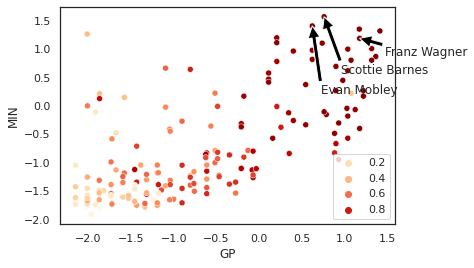

In [ ]:
plot_rookies()